In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

Bad val "cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])" on line #240
	"axes.prop_cycle    : cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])  # color cycle for plot lines
"
	in file "C:\Users\zhaolei\.matplotlib\matplotlibrc"
	Key axes.prop_cycle: 'cycler('color', [348ABD, A60628, 7A68A6, 467821,D55E00,  CC79A7, 56B4E9, 009E73, F0E442, 0072B2])' is not a valid cycler construction: invalid syntax (<string>, line 1)


In [4]:
az.style.use('arviz-darkgrid')

机器学习是一个总括的术语，指的是一系列方法的集合，这些方法可以自动学习数据中的模式，然后使用我们学到的方法来预测未来的数据或在不确定的情况下做出决策。 机器学习和统计学确实是相互交织的主题，如果您采用概率观点，这种联系就很清楚，就像凯文·墨菲（Kevin Murphy）在他的著作《机器学习：概率观点》中所做的那样。 虽然这些领域在概念和数学层面上紧密相连，但术语可能会使连接变得不透明。 因此，让我将ML词汇带入本章中的问题。 使用ML术语，我们说回归问题是监督学习的一个例子。 在机器学习框架下，当我们想学习从到的映射（连续变量）时，我们会遇到回归问题。

有几种方法可以找到线性模型的参数。 一种方法称为最小二乘拟合。 最小二乘返回$ \alpha $和$ \beta $的值，从而在观察到的y与预测y之间产生最低的平均二次误差。 用这种方式表示，估计问题是一个优化问题，即我们试图找到某个函数的最小值或最大值的问题。 优化的替代方法是生成一个完全概率模型。 概率思维为我们提供了许多好处。 我们可以获得$ \alpha $和$ \beta $的最佳值（与优化方法相同），以及对参数值不确定性的估计。 优化方法需要额外的工作才能提供此信息。 此外，概率方法，尤其是在使用诸如PyMC3之类的工具完成时，将使我们能够灵活地使模型适应特定问题，这将在本章中看到。

y ~ $Normal(\mu= \alpha+x\beta,\epsilon)$  

在统计学思维中，y变量服从高斯分布，属性是均值$\mu= \alpha+x\beta$和标准差 $\epsilon$  线性回归模型是高斯模型的扩展，其中均值不是直接估算的，而是作为预测变量和一些其他参数的线性函数计算的。

![title](3_1.png)

#### 对于先前的$ \ alpha $，我们可以通过将值$ \ deta_a $设置为相对较高的数据规模来使用非常平坦的高斯函数。通常，我们不知道截距在哪里，对于一个领域和另一个领域，对于不同的领域知识，其价值可能相差很大。对于我处理过的许多问题，通常以零为中心，并且$ \ deta_a $不大于10，但这只是我的经验（几乎是轶事），涉及一小部分问题，并且不易转移至其他问题。关于斜率，对预期结果有一个总体了解可能比拦截要容易得多。对于许多问题，我们至少可以先验知道斜率的符号。例如，我们希望可变的重量平​​均随高度的变化而增加。对于epsilon，我们可以将$ \ deta_e $设置为变量y的比例上的一个大值，例如，十倍于其标准偏差的值。这些非常模糊的先验保证了先验对后验的影响很小，数据很容易克服。[使用最小二乘法得到的点估计将与具有平坦先验的贝叶斯简单线性回归的最大后验（MAP）（后验模式）一致。]

均匀分布或半柯西分布可以替代半高斯分布。 半柯西分布通常可以很好地进行正则化（有关详细信息，请参见第6章，模型比较），并且Uniform分布通常不是很好的选择，除非您知道参数确实受到硬边界的限制。 如果我们想在某个特定值附近使用非常强的先验值作为标准偏差，则可以使用伽玛分布。 起初，许多软件包中的伽马分布的默认参数设置可能会有些混乱，但是幸运的是，PyMC3允许我们使用形状和比率（可能是最常见的参数设置）或均值和标准偏差（可能更直观）来定义它 参数化，至少对于新手而言）。https: //docs. pymc. io/api/distributions/continuous. html 

![title](3_2.png)

## Simple linear regression

In [23]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

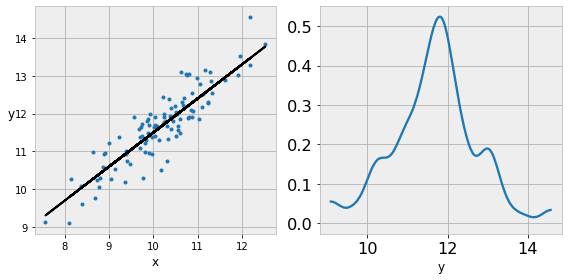

In [3]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()
plt.savefig('B11197_03_02.png', dpi=300)

In [12]:
with pm.Model() as :
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    x = pm.Data("x", x)
    μ = α + β * x
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_g = pm.sample(2000, tune=1000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 3000/3000 [00:21<00:00, 140.07it/s]
The number of effective samples is smaller than 25% for some parameters.


C:\Users\zhaolei\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


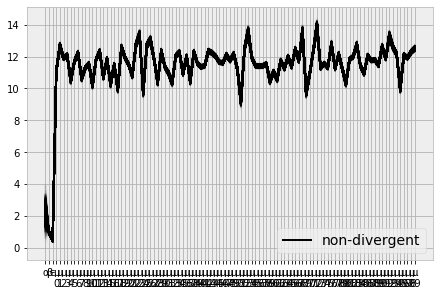

In [6]:
az.plot_parallel(trace_g)  #Plot parallel coordinates plot showing posterior points with and without divergences.

In [13]:
az.summary(trace_g,var_names=['α', 'β', 'ϵ'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,2.132,0.492,1.160,3.019,0.017,0.012,875.0,875.0,867.0,1332.0,1.0
β,0.939,0.048,0.849,1.031,0.002,0.001,885.0,861.0,887.0,1308.0,1.0
ϵ,0.452,0.033,0.389,0.511,0.001,0.001,1692.0,1690.0,1685.0,1820.0,1.0


y_pred = pm. Normal(' y_pred' , mu= α + β * x, sd=ϵ, observed=y)  可以用这行取代 deterministic variable

另外通过var_names 避免画图的时候带上deterministic variable

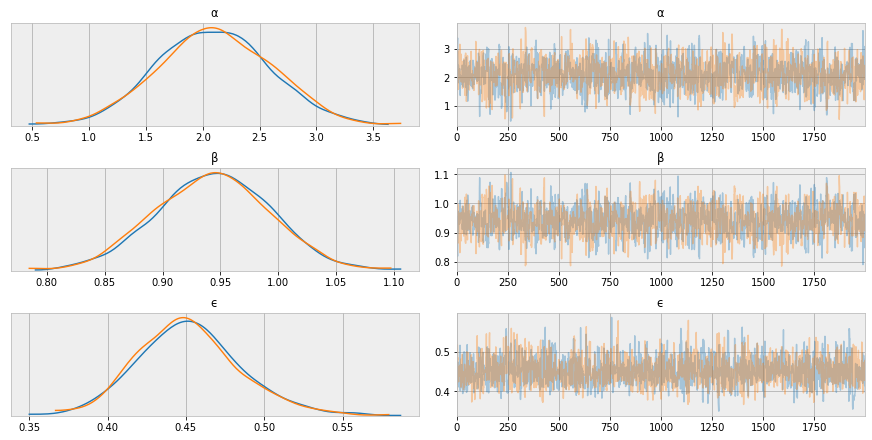

In [10]:
az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ'])
plt.savefig('B11197_03_03.png', dpi=300)

### Linear models and high autocorrelation     线性模型和高自相关

我们在图3.4中看到的相关性是我们假设的直接结果。 不管我们适合数据的哪条线，它们都应该传递一个点，即x变量的平均值和y变量的平均值。 因此，线拟合过程在某种程度上等同于旋转固定在数据中心的直线，例如命运之轮。 斜率的增加意味着截距的减少，反之亦然。 这两个参数将通过模型的定义进行关联。 因此，后部的形状（不包括\\ epsilon $）是一个非常对角的空间。 对于Metropolis-Hastings等采样器（在较小程度上包括NUTS），这可能会带来问题。 有关为何如此的详细信息，请参见第8章，推理引擎。

在继续并为了真实起见之前，让我澄清一下。 仅在最小二乘法（及其假设）下，线才被限制通过数据的平均值才成立。 使用贝叶斯方法，此约束得到缓解。 在后面的示例中，我们将看到，通常，我们在x和y的平均值周围得到线，而不是精确地通过精确均值。 此外，如果我们使用强先验，则最终可能会得到远离x和y均值的直线。 尽管如此，自相关与围绕或多或少定义的点旋转的线有关的想法仍然成立，这就是我们需要了解的关于$\alpha$和$\beta$参数的相关性。

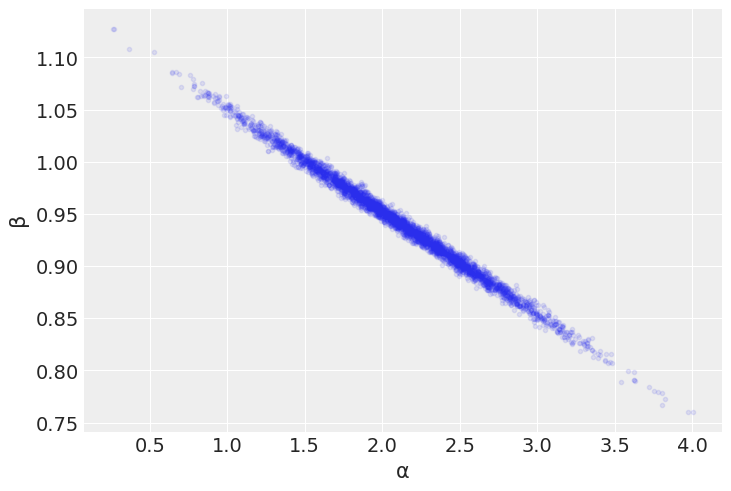

In [8]:
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.1}) #Plot a scatter, kde and/or hexbin matrix with (optional) marginals on the diagonal.
plt.savefig('B11197_03_04.png', dpi=300)

#### 在数据运行前修改它
在运行模型之前，我们甚至可以通过标准化数据来使数据居中和转换。 标准化是统计和ML中线性回归模型的一种常见做法，因为对数据进行标准化后，许多算法的性能会更好。 通过将数据居中并将其除以标准偏差来实现此转换。 从数学上讲，我们有：

![title](3_3.png)

标准化数据的一个优点是，我们总是可以使用相同的弱信息先验，而不必考虑数据的规模。 对于标准化数据，截距将始终为0左右，并且斜率将限制为区间[-1，1]。 另外，通过标准化数据，我们可以用Z分数（即以标准差为单位）进行交谈。 如果有人说某个参数的值是以Z分数为单位的-1.3，则我们会自动知道所讨论的值比平均值低1.3个标准偏差，而与平均值的实际值或标准偏差的实际值无关 数据。 不管原始数据的大小如何，一个Z分数单位的变化就是一个标准偏差的变化。 当使用多个变量时，这可能非常有用。 具有相同比例的所有变量可以简化数据的解释。

### interpreting the posterior

正如我们已经看到的，我们可以使用诸如plot_trace和summary的ArviZ函数来探索后验，或者可以使用我们自己的函数。 对于线性回归，绘制适合数据的平均线以及$ \ alpha $和$ \ beta $的平均值可能会很有用。 为了反映后验的不确定性，我们可以使用从后验中采样的半透明线：

In [11]:
x[:,np.newaxis].shape #np.newaxis的作用就是在这一位置增加一个一维，这一位置指的是np.newaxis所在的位置 ;这样就可以直接和b相乘了

(100, 1)

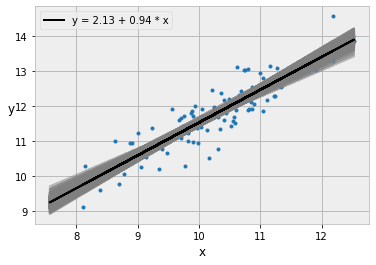

In [24]:
plt.plot(x, y, 'C0.')

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]
         * x[:, np.newaxis], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.savefig('B11197_03_05.png', dpi=300)

请注意，不确定性在中间位置较低，尽管它并没有减少到单个点，也就是说，后验与不完全通过数据均值的线兼容，正如我们已经提到的。

使用半透明线是完全可以的，但是我们可能想在图形上添加一个冷因子，而使用半透明带来说明最高后密度（HPD）间隔$ \ mu $。 实际上，这就是我们在模型中定义确定性变量$ \ mu $的主要原因。 拥有此变量可简化以下代码：

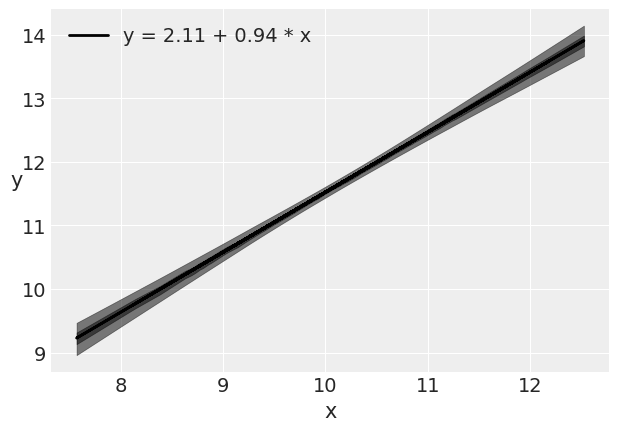

In [22]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hpd(x, trace_g['μ'], credible_interval=0.94, color='k')
sig = az.plot_hpd(x, trace_g['μ'], credible_interval=0.5, color='k')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.savefig('B11197_03_06.png', dpi=300)

In [17]:
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 749.38it/s]


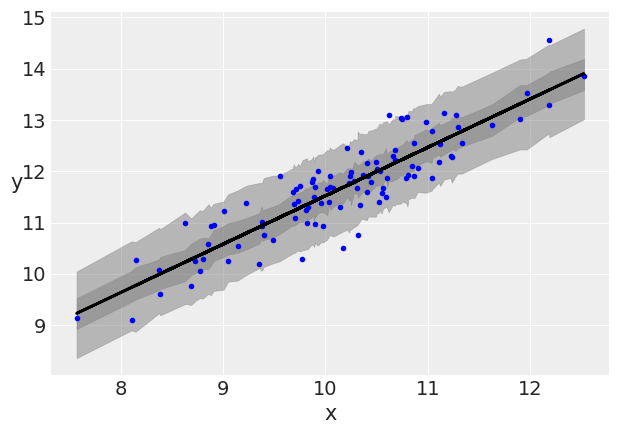

In [23]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray',smooth=False)
az.plot_hpd(x, ppc['y_pred'], color='gray',smooth=False)   #smooth=True 默认

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_07.png', dpi=300)

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:12<00:00, 308.74it/s]


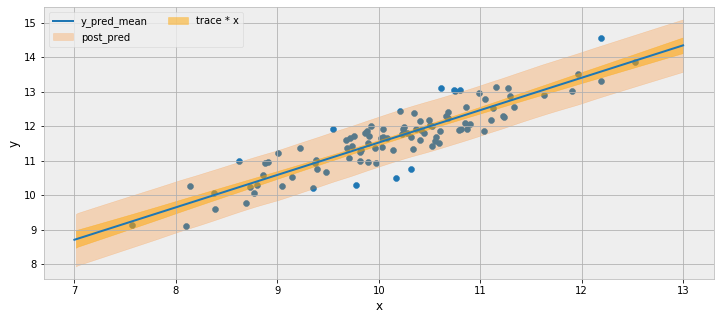

In [27]:
RANDOM_SEED = 8927
np.random.seed(286)

def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def identity(x):
    """Simple identity function"""
    return x


def link(
    post_df: pd.DataFrame,
    slope: str,
    x_seq: np.array,
    itcpt: str = 'α',
    link_fct=identity,
) -> np.array:
    """
    Returns the mean regression trend from a model's trace to inspect the inferred relationship between predictor and outcome.
    Limited to one predictor x_seq.
    Default link function is identity function, as in plain linear regression.
    """
    mus_post_pred = []
    for x_ in x_seq:
        mus_post_pred.append(link_fct(post_df[itcpt] + post_df[slope] * x_).values)

    return np.asarray(mus_post_pred).T

post_g = pm.trace_to_dataframe(trace_g)
age_seq = np.linspace(7, 13)
# lambda calcs
lambdas_post_pred = link(post_g, 'β', age_seq)   #默认截距是a
# outcome calcs
with model_g:
    pm.set_data({"x": age_seq})
    y_post_pred = pm.sample_posterior_predictive(
        trace_g, random_seed=RANDOM_SEED
    )["y_pred"]

# plot
plt.figure(figsize=(12, 5))

plt.scatter(x, y)
az.plot_hpd(
    age_seq,
    y_post_pred,
    credible_interval=0.89,
    fill_kwargs={"alpha": 0.25, "label": "post_pred"},
)
az.plot_hpd(
    age_seq,
    lambdas_post_pred,
    credible_interval=0.89,
    fill_kwargs={
        "alpha": 0.5,
        "color": "orange",
        "label": "trace * x",
    },
)
plt.plot(age_seq, lambdas_post_pred.mean(axis=0), label="y_pred_mean")

plt.xlabel("x")
plt.ylabel("y")
plt.legend(ncol=2) 

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 542.57it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


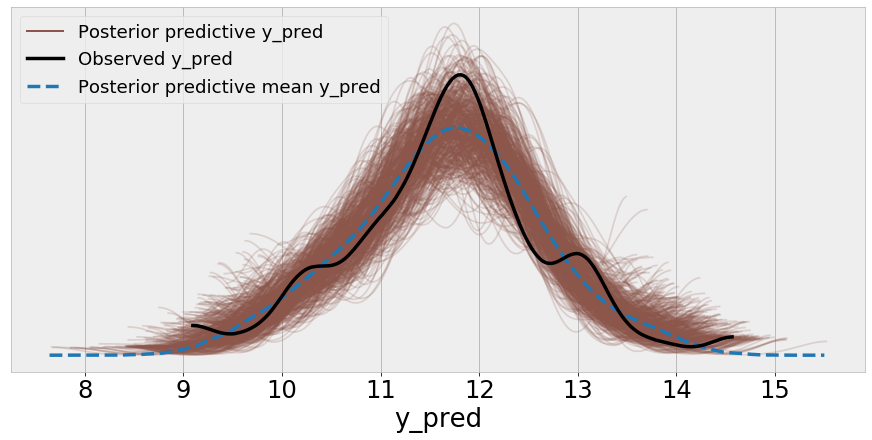

In [33]:
with model_g:
    pm.set_data({"x": x})
    y_post_pred = pm.sample_posterior_predictive(trace_g, samples=500)
    ppc=az.from_pymc3(trace=trace_g,posterior_predictive=y_post_pred)
az.plot_ppc(ppc, figsize=(12,6));

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000211ACE93FD0>],
      dtype=object)

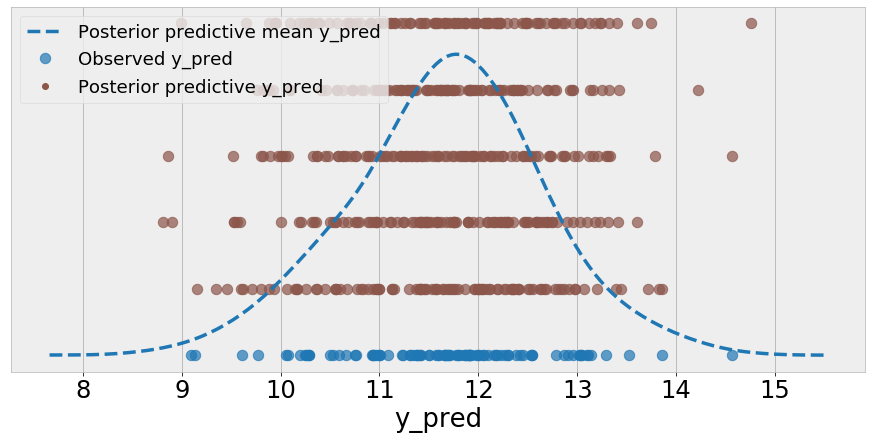

In [34]:
az.plot_ppc(ppc, figsize=(12,6),kind='scatter')

#### Pearson correlation coefficient

有时，我们想测量两个变量之间的（线性）相关程度。 两个变量之间线性相关性的最常见度量是皮尔森相关系数，通常用小写字母r表示。 当r=+1时，我们有一个完美的正线性相关，即一个变量的增加预示着另一个变量的增加。 当r=-1时，我们有一个完美的负线性相关性，一个变量的增加预示着另一个变量的减少。 当r=0时，我们没有线性关系，我们将获得中间值。 重要的是要始终牢记两个方面：皮尔逊相关系数对非线性相关没有任何说明。 我们不应混淆回归的斜率。 以下来自维基百科的图片是一个不错的选择：

![title](wikiimg.webp)

r和回归斜率之间的部分混淆可以通过以下关系来解释：$ r=\beta \frac {\sigma_x}{\sigma_y}$

也就是说，斜率（$\beta$）和皮尔逊相关系数（r）具有相同的值，但仅当x和y的标准偏差相等时才具有。 注意，例如，当我们标准化数据时，这是正确的。 为了进一步澄清：
皮尔逊相关系数（r）是两个变量之间的相关程度的度量，并且始终限于区间[-1，1]。 数据规模无关紧要。
线性回归（$\beta$）的斜率表示的每单位变化有多少变化，并且可以取任何实际值。

皮尔逊系数与称为确定系数的数量有关，对于线性回归模型，这只是皮尔逊系数的平方，即$ r ^ 2 $（或有时$ R ^ 2 $）。 这被表示为r平方，并且可以定义为预测值的方差除以数据的方差。 因此，可以将其解释为从自变量预测的因变量中方差的比例。 对于贝叶斯线性回归，预测值的方差可以大于数据的方差，这将导致$ R ^ 2 $大于1，那么一个好的解决方案是按如下方式定义$ R ^ 2 $：

In [25]:
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)

az.r2_score(y, ppc['y_pred'])        #评估分值

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 701.17it/s]


r2        0.787742
r2_std    0.006301
dtype: float64

### The multivariate normal distribution    Pearson coefficient from a multivariate Gaussian 多元高斯的Pearson系数
Actually the bivariate 实际上是二元的。计算皮尔逊系数的另一种方法是估算多元高斯分布的协方差矩阵。 多元高斯分布是将高斯分布推广到多个维度。 让我们关注二维的情况，因为这就是我们现在要使用的。 一旦我们理解了双变量情况，将其推广到更高维度几乎是微不足道的。 为了全面描述双变量高斯分布，我们需要两种方法（或具有两个元素的向量），每个边际高斯分布一个。 我们还需要两个标准差，对吗？ 好吧，不完全是； 我们需要一个2 x 2的协方差矩阵，如下所示：

![title](3_4.png)

$\Sigma$这是希腊的大写西格玛字母，通常使用它来表示协方差矩阵。 在主对角线上，我们具有每个变量的方差，表示为它们的标准偏差和的平方。 矩阵中的其余元素是协方差（变量之间的方差），它们以各个标准差和变量之间的皮尔逊相关系数表示。 请注意，我们只有一个，因为我们只有两个维度（或变量）。 对于三个变量，我们将具有三个皮尔森系数。

以下代码生成双变量高斯分布的等高线图，且两个均值均固定为（0，0）。 标准偏差之一为固定1，而另一个标准偏差为1或2，而皮尔逊相关系数则为不同值：

In [35]:
pos[:, :, 0]

array([[-5. , -5. , -5. , ..., -5. , -5. , -5. ],
       [-4.9, -4.9, -4.9, ..., -4.9, -4.9, -4.9],
       [-4.8, -4.8, -4.8, ..., -4.8, -4.8, -4.8],
       ...,
       [ 4.7,  4.7,  4.7, ...,  4.7,  4.7,  4.7],
       [ 4.8,  4.8,  4.8, ...,  4.8,  4.8,  4.8],
       [ 4.9,  4.9,  4.9, ...,  4.9,  4.9,  4.9]])

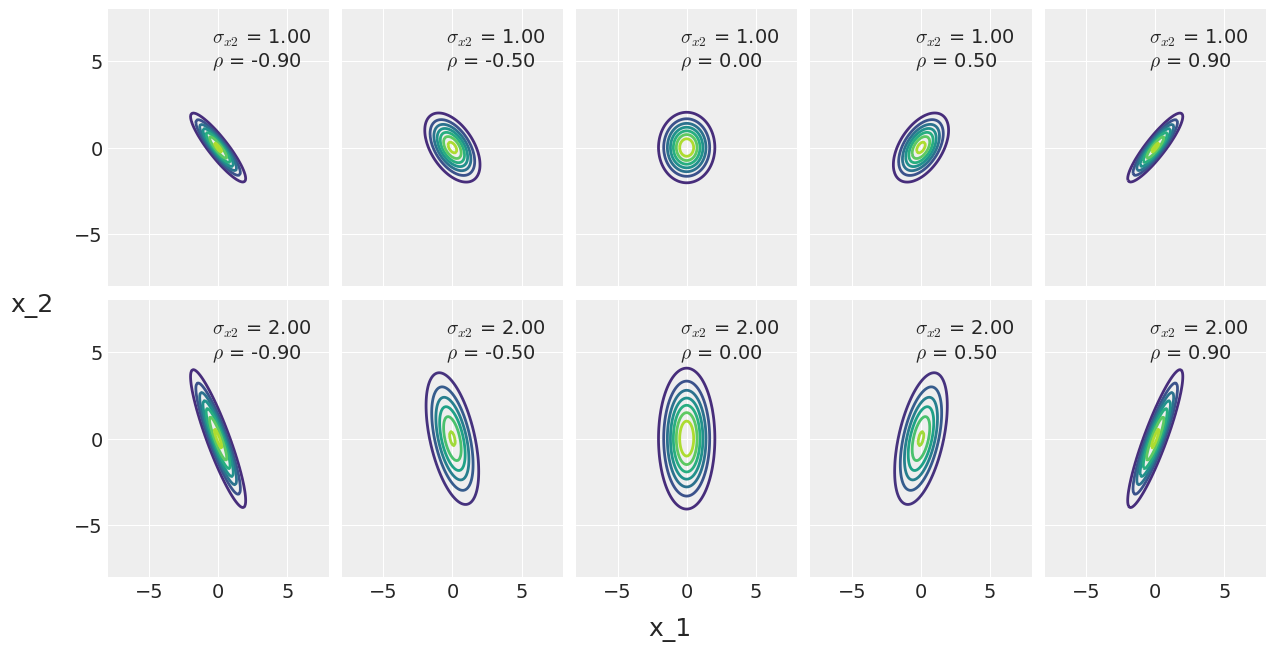

In [26]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0,
                      label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)
plt.savefig('B11197_03_08.png', dpi=300)

既然我们知道了多元高斯分布，就可以用它来估计皮尔森相关系数。 由于我们不知道协方差矩阵的值，因此必须先验先验。 一种解决方案是使用Wishart分布，它是多元正态逆协方差矩阵的共轭先验。 Wishart分布可以看作是我们之前看到的对更高维度的γ分布的概括，也可以看作是ki2分布的概括。 第二种选择是先使用LKJ（有关详细信息，请参见https://docs.pymc.io/notebooks/LKJ.htm）。 这是相关矩阵（而不是协方差矩阵）的先验知识，这可能很方便，因为考虑到相关性通常更有用。 我们将探索第三个选项，并将直接为σ_1，σ_2和$\rho$放置先验，然后使用这些值手动构建协方差矩阵：

In [36]:
data = np.stack((x, y)).T
with pm.Model() as pearson_model:

    μ = pm.Normal('μ', mu=data.mean(0), sd=10, shape=2)

    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1., 1.)
    r2 = pm.Deterministic('r2', ρ**2)

    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
                         [σ_1*σ_2*ρ, σ_2**2]))

    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data)

    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\zhaolei\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


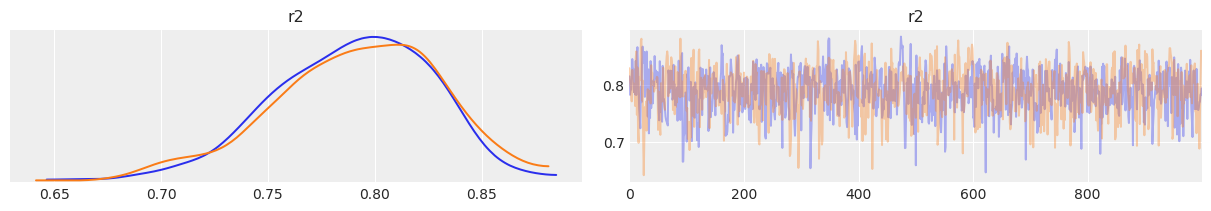

In [41]:
az.plot_trace(trace_p, var_names=['r2'])
plt.savefig('B11197_03_9.png', dpi=300)

In [42]:
az.summary(trace_p, var_names=['r2'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
r2,0.79,0.039,0.71,0.856,0.001,0.001,1019.0,1010.0,993.0,1074.0,1.0


In [43]:
az.summary(trace_p)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],10.153,0.097,9.958,10.329,0.003,0.002,967.0,967.0,968.0,987.0,1.00
μ[1],11.668,0.102,11.484,11.863,0.003,0.002,969.0,969.0,967.0,983.0,1.00
σ_1,0.944,0.069,0.821,1.073,0.002,0.002,1065.0,1037.0,1117.0,881.0,1.00
σ_2,0.996,0.073,0.865,1.133,0.002,0.002,983.0,949.0,1043.0,709.0,1.01
ρ,0.889,0.022,0.844,0.927,0.001,0.000,1023.0,1019.0,993.0,1074.0,1.00
r2,0.790,0.039,0.710,0.856,0.001,0.001,1019.0,1010.0,993.0,1074.0,1.00


## Robust linear regression

假设数据遵循高斯分布，则在许多情况下是完全合理的。 通过假设高斯性，我们不一定要说数据确实是高斯性的。 相反，我们说这是给定问题的合理近似值。 其他分布也是如此。 正如我们在上一章中所看到的，有时，这种高斯假设会失败，例如在存在异常值的情况下。 我们了解到，使用学生的t分布是一种有效处理异常值并获得更可靠推断的方法。 完全相同的想法可以应用于线性回归。

为了说明学生的t分布对线性回归带来的稳健性，我们将使用一个非常简单而美观的数据集：Anscombe四重奏组的第三个数据组。 如果您不知道Anscombe四重奏是什么，请记得稍后在Wikipedia（https：// en。Wikipedia。org / wiki / Anscombe％27s_quartet）进行检查。 我们可以使用pandas上传它。 我们将以数据为中心，只是为了使采样器更轻松—即使像NUTS这样的酷采样器也需要不时的帮助：【Anscombe的四重奏包含四个数据集，这些数据集具有几乎相同的简单描述性统计数据，但在绘制图形时显得非常不同。 每个数据集由十一个（x，y）点组成。 它们由统计学家Francis Anscombe于1973年建造，旨在证明在分析数据之前对数据进行图形绘制的重要性以及离群值对统计属性的影响。 他将这篇文章描述为旨在打击统计学家的印象，即“数值计算是精确的，但图表是粗糙的”。[1]第一个散点图（左上方）似乎是简单的线性关系，对应于相关的两个变量并且遵循正态性假设。第二个图（右上方）分布不正常；尽管可以观察到两个变量之间存在明显的关系，但它不是线性的，并且Pearson相关系数不相关（更一般的回归和相应的确定系数更合适）。在第三个图中（左下图），分布是线性的，但是具有不同的回归线，该回归线被一个异常值所抵消，该异常值施加了足够的影响以更改回归线并将相关系数从1降低到0.816（稳健回归会被要求）。最后，第四张图（右下图）显示了一个示例，即使两个变量之间的关系不是线性的，但离群值足以产生高相关系数。
四方仍然经常被用来说明在开始根据特定类型的关系进行分析之前以图形方式查看一组数据的重要性，以及描述实际数据集的基本统计特性不足。[2] [3] [4 ] [5] [6]】

![title](Anscombe's_quartet.webp)

In [76]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

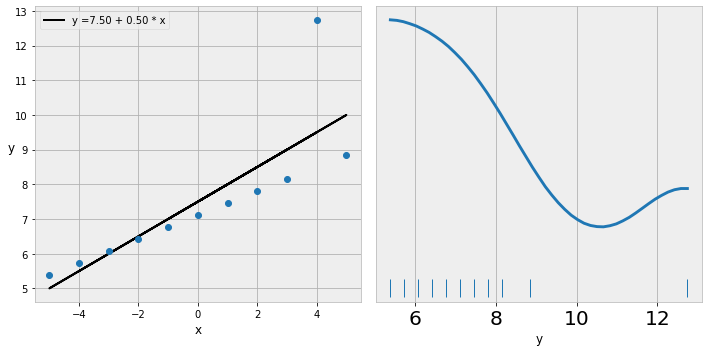

In [77]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()
plt.savefig('B11197_03_10.png', dpi=300)

在以下模型中，我们使用移位指数以避免v的值接近零。 非移位指数对接近零的值施加了过多的权重。 以我的经验，这对于没有中度异常值的数据很好，但是对于具有极端异常值的数据（或具有几个散点的数据），例如在Anscombe的第三个数据集中，最好避免使用如此低的值。 捏一点盐就可以吃了，以及其他先前的建议。 默认值是一个很好的起点，但是没有必要坚持下去。 v的其他常见先验是gamma（2，0. 1）或gamma（mu = 20，sd = 15）：

In [85]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    x_3 = pm.Data("x_3", x_3)
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)

    trace_t = pm.sample(2000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν_, ϵ, β, α]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:11<00:00, 208.92it/s]
The acceptance probability does not match the target. It is 0.8901541531872447, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9099552431070662, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\zhaolei\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument

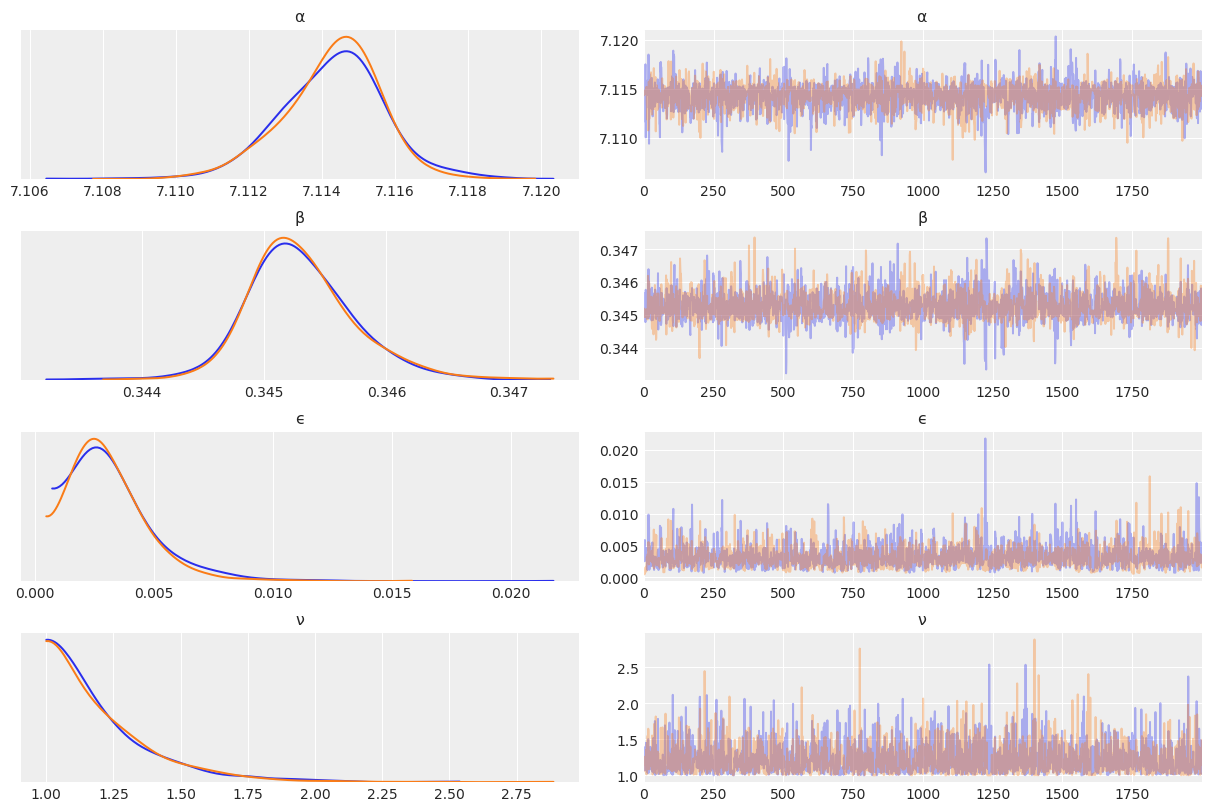

In [46]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.plot_trace(trace_t, var_names=varnames);

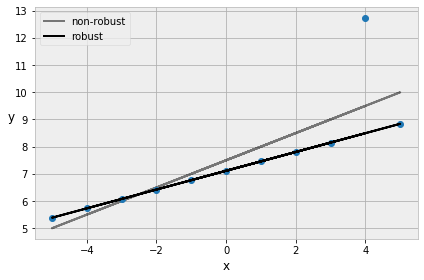

In [39]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

plt.savefig('B11197_03_11.png', dpi=300)

尽管非稳健拟合试图折衷并包含所有点，但稳健的贝叶斯模型model_t自动丢弃一个点，并拟合一条恰好穿过所有其余点的线。 我知道这是一个非常特殊的数据集，但对于更真实和更复杂的数据集来说，仍然保留着该信息。 由于尾部较重，学生的t分布对与大量数据相距甚远的点的重视程度较低。 在继续之前，花一点时间来思考一下参数的值（由于中间的兴趣不大，我省略了中间参数）：

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:16<00:00, 249.06it/s]


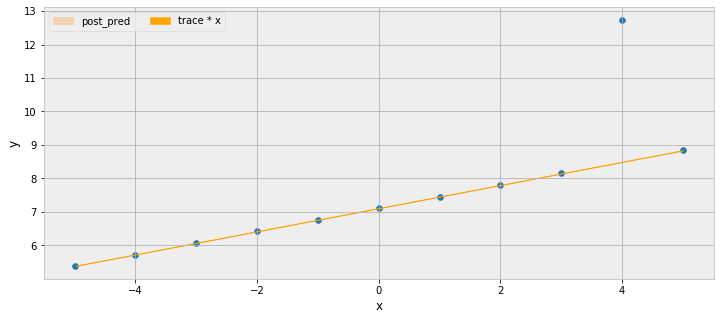

In [81]:
post_g = pm.trace_to_dataframe(trace_t)
age_seq = np.linspace(-5, 5,100)
# lambda calcs
lambdas_post_pred = link(post_g, 'β', age_seq)   #默认截距是a
# outcome calcs
with model_t:
    pm.set_data({"x_3": age_seq})
    y_post_pred = pm.sample_posterior_predictive(
        trace_t, random_seed=RANDOM_SEED
    )["y_pred"]

# plot
plt.figure(figsize=(12, 5))
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()
plt.scatter(x_3, y_3)
az.plot_hpd(
    age_seq,
    y_post_pred,
    credible_interval=0.89,
    fill_kwargs={"alpha": 0.25, "label": "post_pred"},
)
az.plot_hpd(
    age_seq,
    lambdas_post_pred,
    credible_interval=0.89,
    fill_kwargs={
        "alpha": 1.0,
        "color": "orange",
        "label": "trace * x",
    },
)
#plt.plot(age_seq, lambdas_post_pred.mean(axis=0), label="y_pred_mean")

plt.xlabel("x")
plt.ylabel("y")
plt.legend(ncol=2) 

In [86]:
az.summary(trace_t,var_names = ['α', 'β', 'ϵ', 'ν'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.111,7.117,0.000,0.000,2101.0,2101.0,2165.0,1717.0,1.0
β,0.345,0.000,0.345,0.346,0.000,0.000,1309.0,1308.0,1604.0,1282.0,1.0
ϵ,0.003,0.002,0.000,0.006,0.000,0.000,1176.0,1176.0,856.0,408.0,1.0
ν,1.209,0.200,1.000,1.571,0.004,0.003,2696.0,2696.0,1276.0,845.0,1.0


In [ ]:
这个置信区间非常窄。。。所以图上几乎重叠在一起

In [49]:
ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t, random_seed=2)

C:\Users\zhaolei\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 99.37it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


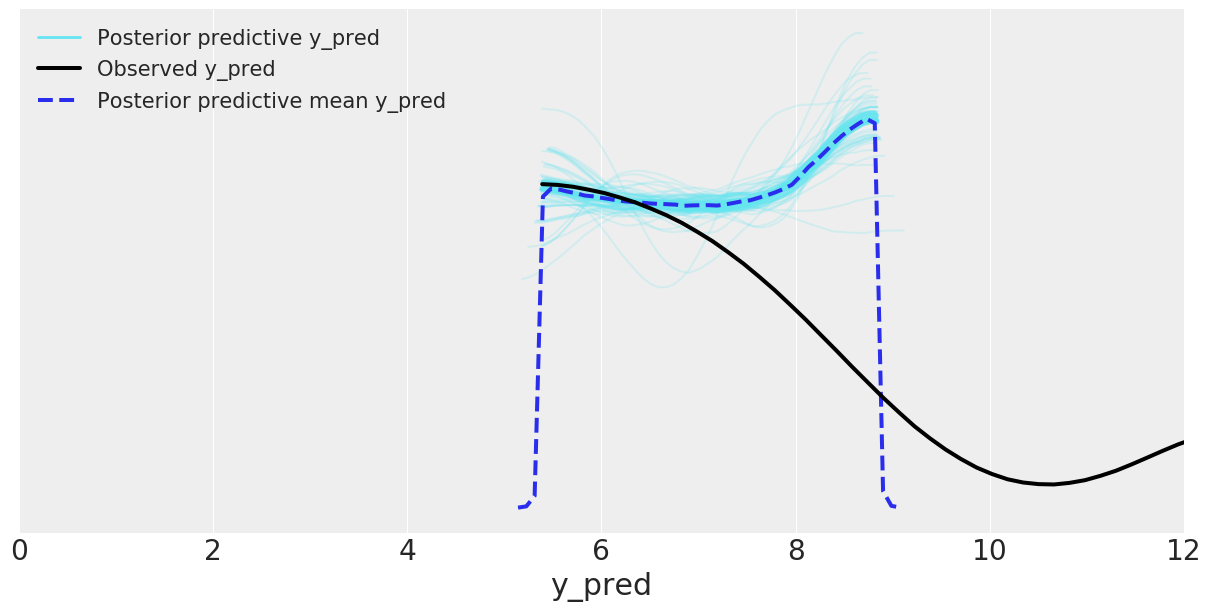

In [50]:
data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
plt.xlim(0, 12)
plt.savefig('B11197_03_12.png', dpi=300)

In [116]:
data_ppc 

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

对于大部分数据，我们得到了很好的匹配。 还要注意，我们的模型预测的值会远离整体，而不是整体的两侧。 就我们当前的目的而言，此模型运行良好，不需要进一步更改。 但是，请注意，对于某些问题，我们可能希望避免这种情况。 在这种情况下，我们可能应该返回并更改模型，以将y_pred的可能值限制为正值。

## Hierarchical linear regression

In [54]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000221C53C77B8>,
      dtype=object)

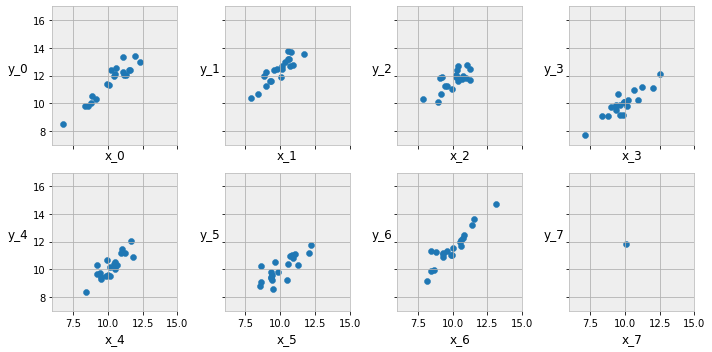

In [7]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)  #将多维数组降为一维
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B11197_03_13.png', dpi=300)

In [8]:
x_centered = x_m - x_m.mean()

In [16]:
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    trace_up = pm.sample(2000,cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, ϵ, β, α_tmp]
Sampling chain 1, 1 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:05<00:00, 417.64it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


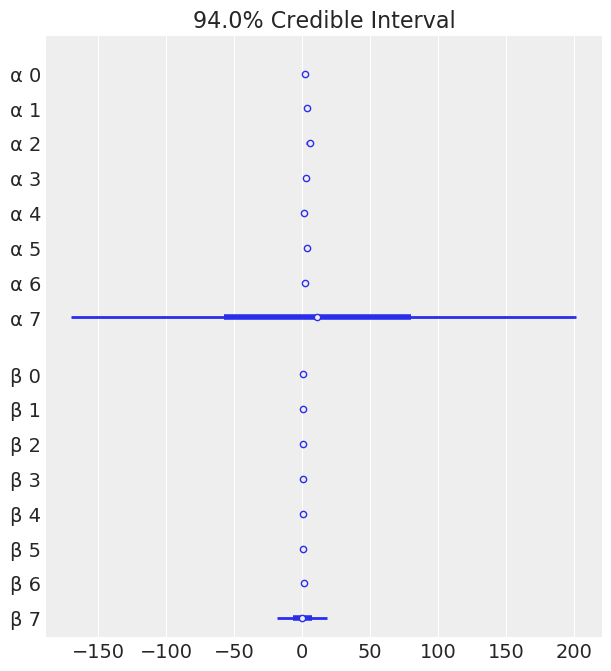

In [58]:
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)
plt.savefig('B11197_03_14.png', dpi=300)

相较于其余参数，参数7非常宽：您可能已经猜到了发生了什么—试图使一条线穿过单个点没有意义。 我们至少需要两点，否则参数和是无界的。 除非我们提供更多信息，否则这是完全正确的。 我们可以通过使用先验来做到这一点。 设置强先验的for可以导致一组明确定义的线路，即使对于一个数据点也是如此。 传达信息的另一种方法是定义层次模型，因为层次模型允许信息在组之间共享，从而缩小了估计参数的合理值。 在我们有稀疏数据组的情况下，这变得非常有用。 在此示例中，我们将数据的稀疏性发挥到了极致—一个具有单个数据点的组！

我们还添加了几行代码，将参数转换回原始的非中心比例。 请记住，这不是强制性的。 只要我们在解释结果时牢记这一点，就可以将参数保持在转换后的范围内：


 <img src='B11197_03_15.png' width="700">

In [9]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(1000,cores=1)  #增加tune

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling chain 1, 52 divergences: 100%|███████████████████████████████████████████| 1500/1500 [00:07<00:00, 208.14it/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


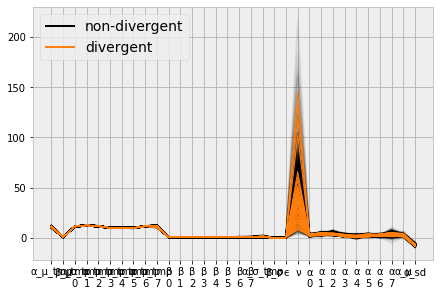

In [10]:
az.plot_parallel(trace_hm)

In [12]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(1000,cores=1,tune= 1000,target_accept=0.9)  #增加tune

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling chain 1, 5 divergences: 100%|████████████████████████████████████████████| 2000/2000 [00:13<00:00, 145.23it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


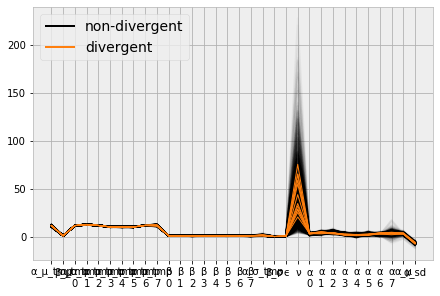

In [13]:
az.plot_parallel(trace_hm)

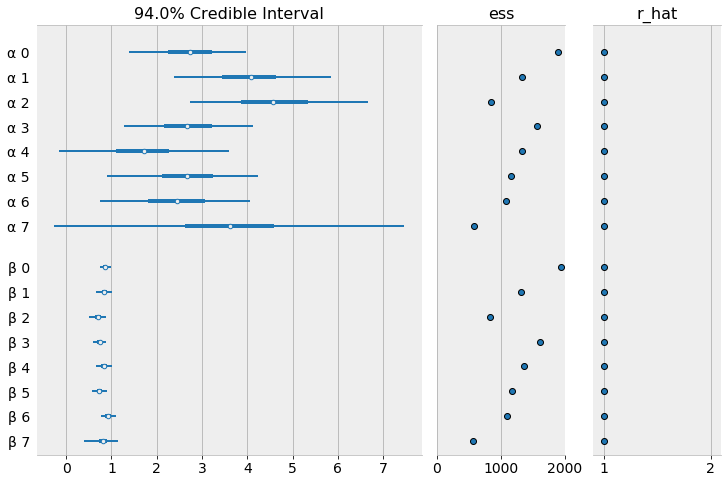

In [14]:
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True,r_hat=True,ess=True)
plt.savefig('B11197_03_16.png', dpi=300)

A good way to compare models using az. plot_forest() is to show the
parameters of both models ( unpooled_model , hierarhical_model ) simultaneously in
the same plot. To do this, you just need to pass a list of traces.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EA57DEACF8>,
      dtype=object)

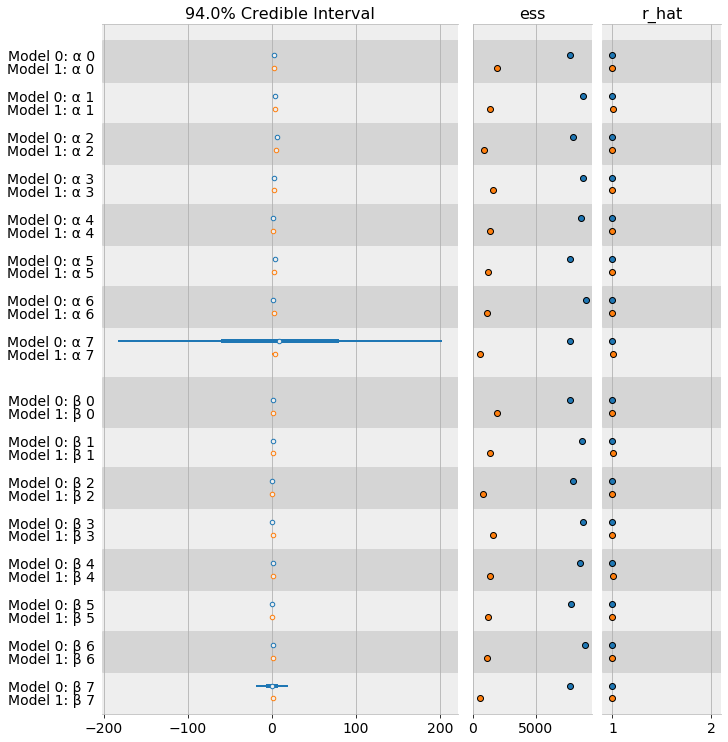

In [17]:
az.plot_forest([trace_up,trace_hm], var_names=['α', 'β'], combined=True,r_hat=True,ess=True)

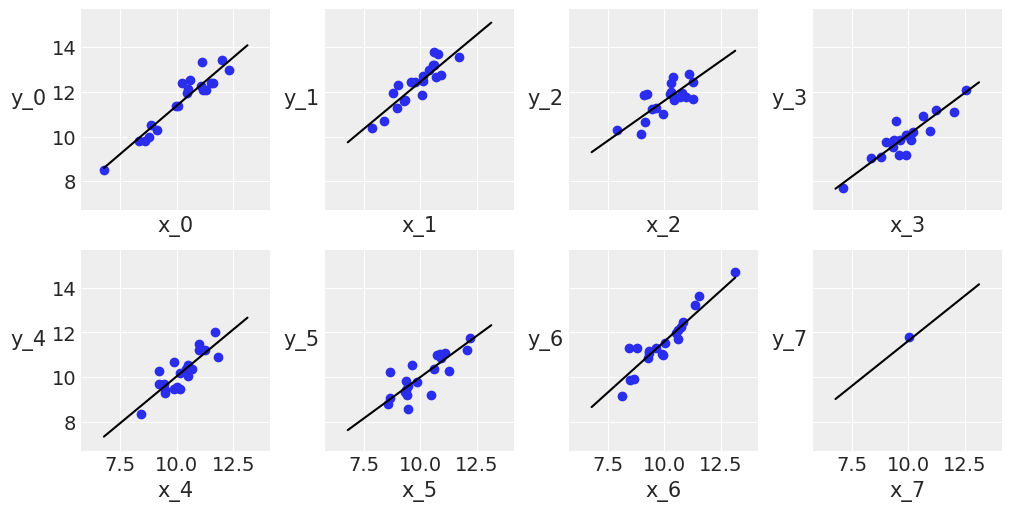

In [31]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.savefig('B11197_03_17.png', dpi=300)

使用分层模型，我们能够将一条线拟合到单个数据点，如图3.17所示。 起初，这听起来可能很奇怪，甚至有些可疑，但这只是层次模型结构的结果。 每条线都由其他组的线告知，因此我们并没有真正将一条线调整为单个点。 相反，我们正在将一条线调整到一个由其他组中的点告知的点。

## Correlation, causation, and the messiness of life 相关性，因果关系和生活的混乱

假设我们要预测冬天要为家中的天然气供气的费用，并假设我们知道我们居住地区的太阳辐射量。在此示例中，太阳辐射将是自变量x，而账单是因变量y。非常重要的一点是要注意，在给定帐单的情况下，没有什么可以禁止我们反转问题并询问太阳辐射量。如果我们建立线性关系（或其他线性关系），则可以从转到y，反之亦然。我们将变量称为独立变量，因为模型无法预测其值。相反，它是模型的输入，因变量是输出。我们说一个变量的值取决于另一个变量的值，因为我们建立了一个模型来指定这种依赖性。我们没有在变量之间建立因果关系，也没有说x导致y。始终记住以下箴言，相关性并不意味着因果关系。让我们进一步发展这个想法。即使我们能够根据太阳辐射和天然气账单中的太阳辐射来预测房屋的天然气账单，我们也可以同意，通过改变太阳辐射的辐射量来控制太阳辐射的数量并非正确。我们家的恒温器！但是，的确，较高的太阳辐射可能与较低的燃气费用有关。

因此，重要的是要记住，我们正在建立的统计模型是一回事，而与变量相关的物理机制是另一回事。 为了确定可以用因果关系来解释相关性，我们需要在问题描述中添加一个合理的物理机制。 相关性是远远不够的。http://www.tylervigen.com/spurious-correlations

建立因果关系时，相关性没有用吗？ 实际上，如果我们执行经过精心设计的实验，则关联可以完全支持因果关系。 例如，我们知道全球变暖与大气中CO 2含量的增加高度相关。 仅从这一观察结果，我们不能得出结论，较高的温度是否引起了CO 2含量的增加，还是较高的碳酸气体使温度升高了。

甚至可能发生的情况是，我们没有考虑到第三个变量，并且该变量会产生更高的温度和更高的CO 2水平。但是，请注意这一点，我们可以进行实验以深入了解此问题。以下是一个可能的实验；我们建造了一组装有不同数量CO 2的玻璃罐。我们可以让一个使用常规空气（其中包含约0.04％的CO 2），而另一个可以使用不断增加的CO 2量。然后，我们让这些水箱接受三小时的阳光照射。如果这样做，我们将验证具有较高CO 2水平的储罐具有较高的最终温度。因此，我们将得出结论，确实CO 2是一种温室效应气体。使用相同的实验，我们还可以在实验结束时测量CO 2的浓度，以检查温度不会导致CO 2水平升高，至少不会从空气中升高。正是这种实验设置与统计模型一起，为支持导致全球变暖的CO 2排放提供了证据。【控制变量】

在此示例之后，我们将讨论的另一个重要方面是，即使将太阳辐射和天然气账单连接在一起，并且也许可以使用太阳辐射来预测天然气账单，但关系更为复杂，并且涉及其他变量。实际上，较高的温度会导致较高的CO 2含量，因为海洋是CO 2的储集层，并且温度升高时，CO 2在水中的溶解度较低。而且，较高的太阳辐射意味着将更多的能量传递给房屋。一部分能量被反射，一部分转化为热量，一部分热量被房屋吸收，一部分损失到环境中。散发的热量取决于几个因素，例如外部温度和风速。然后，我们有一个事实，即天然气账单还会受到其他因素的影响，例如国际石油和天然气价格，公司的成本/利润（及其贪婪程度）以及政府监管的严格程度。公司。

总而言之，生活是一团糟，问题通常不容易理解，情境总是很重要的。 统计模型可以帮助我们获得更好的解释，减少做出无意义的陈述的风险，并获得更好的预测，但是这些都不是自动的。

## Polynomial regression 多项式回归

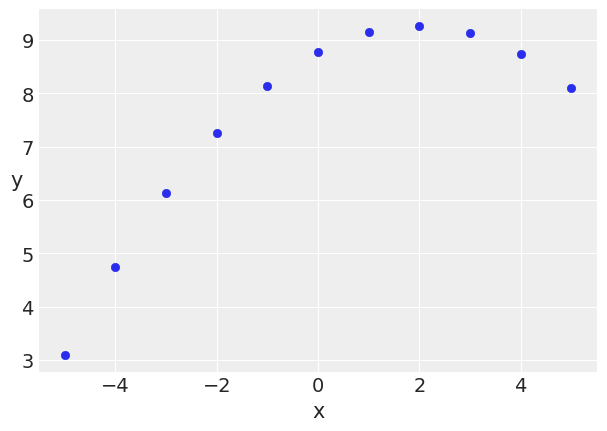

In [62]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_18.png', dpi=300)

In [63]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    mu = α + β1 * x_2 + β2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)

    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:20<00:00, 248.74draws/s]
The acceptance probability does not match the target. It is 0.9019036492497541, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9023762717162468, but should be close to 0.8. Try to increase the number of tuning steps.


In [34]:
#az.plot_trace(trace_poly);

In [65]:
az.summary(trace_poly)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,8.768,0.001,8.766,8.770,0.0,0.0,1464.0,1464.0,1852.0,1671.0,1.0
β1,0.500,0.000,0.500,0.500,0.0,0.0,1925.0,1925.0,2150.0,1667.0,1.0
β2,-0.127,0.000,-0.127,-0.127,0.0,0.0,1561.0,1561.0,1760.0,1376.0,1.0
ϵ,0.002,0.001,0.001,0.003,0.0,0.0,916.0,822.0,1268.0,1638.0,1.0


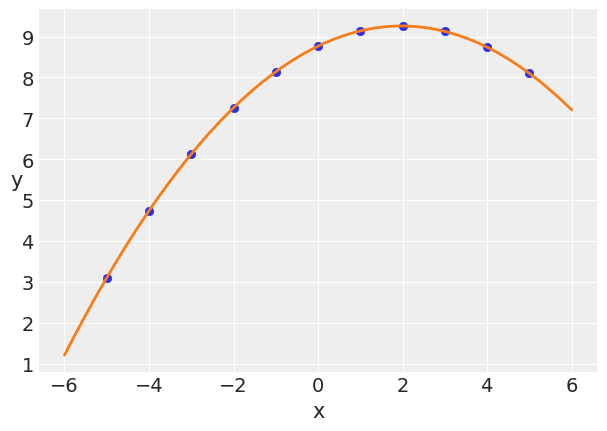

In [64]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * \
    x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B11197_03_19.png', dpi=300)

多项式回归的问题之一是参数的解释。 如果我们想知道y是如何随x的单位变化而变化的； 我们不能只检查$ \ beta1 $的值，因为$ \ beta2 $和更高的系数（如果存在）会对这样的数量产生影响。 因此，$ \ beta $系数不再是斜率，而是其他。 在前面的示例中，$ \ beta1 $为正，因此曲线以正斜率开始，但是$ \ beta2 $为负，因此，一段时间后，线开始向下弯曲。 因此，就像我们有两种力量在发挥作用，一种力量向上推而另一种力量向下推。 相互作用取决于x的值。 当x <= 11（在原始比例上或居中比例为2）时，主要贡献来自$ \ beta1 $，而在x> = 11 $ \ beta2 $中占主导。

解释参数的问题不仅仅是数学问题。 如果是这种情况，我们可以通过仔细检查和理解模型来解决。 问题在于，在许多情况下，在我们的领域知识中，参数未转换为有意义的数量。 我们不能将它们与细胞的新陈代谢率，遥远的星系所散发的能量或房屋中的卧室数量联系起来。 它们只是我们可以调整以改善贴合性的点，但没有明确的物理意义。 在实践中，大多数人会同意，阶数大于2或3的多项式通常不是非常有用的模型，因此首选替代项，例如高斯过程，这是第7章“高斯过程”的主要主题。

如我们所见，当$ \ beta2 $等于零时，我们可以将线视为抛物线的子模型，而当$ \ beta2 $和$ \ beta3时，线也是三次模型的子模型。 $等于零。 当然，当时，抛物线是三次方的子模型。 好的，我将在这里停止，但是我认为您已经注意到了这种模式。 这表明，原则上我们可以使用多项式回归来拟合任意复杂模型。 我们只是建立了具有正确顺序的多项式。 我们可以通过逐个增加阶数来完成此操作，直到观察不到拟合的任何改进为止，或者可以构建无限次多项式，然后以某种方式使所有不相关的系数为零，直到我们完全拟合数据为止。 为了检验这个想法，我们可以从一个非常简单的例子开始。 让我们使用二次模型来拟合Anscombe数据集的第三组。 当您这样做时，我会在这里等...我还在等，不用担心...

In [66]:
with pm.Model() as model_poly_3:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    mu = α + β1 * x_2 + β2 * x_2**2

    y_pred = pm.StudentT('y_pred', mu=mu,
                         sd=ϵ, nu=ν, observed=y_3)

    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_, ϵ, β2, β1, α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:21<00:00, 233.50draws/s]
The acceptance probability does not match the target. It is 0.8932063558624307, but should be close to 0.8. Try to increase the number of tuning steps.


In [68]:
az.summary( trace_t)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.002,7.110,7.118,0.000,0.000,1899.0,1899.0,1943.0,1756.0,1.0
β1,0.345,0.001,0.344,0.347,0.000,0.000,1675.0,1671.0,2011.0,1410.0,1.0
β2,0.000,0.000,-0.000,0.000,0.000,0.000,1511.0,847.0,1672.0,1026.0,1.0
ϵ,0.004,0.002,0.001,0.007,0.000,0.000,1490.0,1490.0,1193.0,902.0,1.0
ν_,0.216,0.206,0.000,0.596,0.004,0.003,2221.0,2221.0,1317.0,893.0,1.0
ν,1.216,0.206,1.000,1.596,0.004,0.003,2221.0,2221.0,1317.0,893.0,1.0


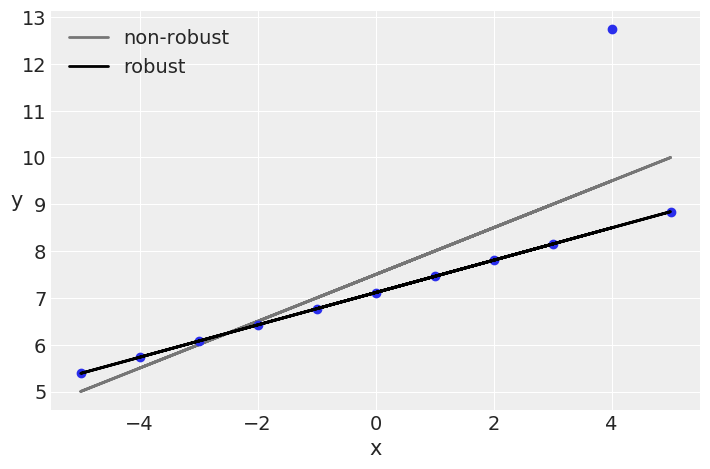

In [69]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m1 = trace_t['β1'].mean()
beta_m2 = trace_t['β2'].mean()
plt.plot(x_3, alpha_m + beta_m1 * x_3+beta_m2 * (x_3**2), c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

好的，如果您确实进行了练习，您将自己观察到可以使用二次模型拟合一条线。虽然以前的简单实验似乎验证了为拟合数据构建无限阶多项式的想法，但我们应该遏制我们的热情。通常，使用多项式拟合数据并不是最好的主意。为什么？因为我们拥有哪些数据并不重要。原则上，总是可以找到一个完美地拟合数据的多项式！实际上，很容易计算出多项式应具有的确切阶数。为什么拟合数据完全有问题？好吧，这是第6章“模型比较”的主题，但会扰人警觉！通常，完全适合您当前数据的模型在拟合/描述未观察到的数据方面做得很差。这样做的原因是任何真实的数据集都将包含噪声，有时（希望）是一个有趣的模式。任意的超复杂模型将适合噪声，从而导致较差的预测。这称为过拟合，是统计和ML中的普遍现象。多项式回归使过拟合时的稻草人很方便，因为它很容易看到问题。这产生了直觉，我们可以将其转换为更复杂的模型，这可能导致过度拟合而没有我们的真正注意。分析数据时，部分工作是确保模型不会过拟合。我们将在第6章“模型比较”中详细讨论该主题。

## Multiple Linear regression  多元线性回归

我们可以轻松地将简单的线性回归模型扩展为处理多个自变量。 我们将此模型称为多元线性回归（不要与multivariate linear regression混淆，因为我们有多个因变量）。Thus, the multiple linear regression model is essentially the same as the simple linear regression model, the only difference being that now is a vector and is a matrix.

In [135]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T   #100*2
X_mean = X.mean(axis=0, keepdims=True) #
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [139]:
y.mean()

14.596926331037489

In [136]:
y_centered = y - y.mean(axis=0, keepdims=True)

In [75]:
np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).shape

(2, 100)

In [77]:
X_centered.T

array([[ 0.05718761, -1.66293726, -0.21396902, -0.11632421,  0.5307651 ,
         0.50955219, -0.00739098,  2.04397023, -0.09869204,  0.44391586,
        -1.26059238, -1.19193105,  1.798142  , -0.98573609, -0.35979076,
         1.61286718,  1.1284822 ,  0.82143518, -0.64207694, -0.12529711,
        -0.12151386, -0.65428341,  1.71395978, -0.58821929,  0.5364253 ,
         2.05831508,  0.35667891,  0.51006047,  0.36432723, -0.72435458,
         0.7319338 , -0.47180781,  0.42986745,  0.31150419,  0.76210541,
         1.48159842, -1.27515168, -0.08883103, -0.03171598, -0.19377088,
        -0.31903304, -0.45266227, -0.45223714, -0.84631363, -0.54222129,
        -2.33223245,  0.84889328,  0.56656771,  0.29240272, -0.34877292,
         2.26475972, -2.18844711, -0.25033645, -1.29878576, -0.40113088,
        -1.67772096, -1.13163377,  0.16632495, -0.8176352 , -0.42205038,
         0.02798467, -0.27404883,  1.39828932, -0.37452493,  2.10361686,
         0.53292088, -0.09231034, -1.04211323, -1.1

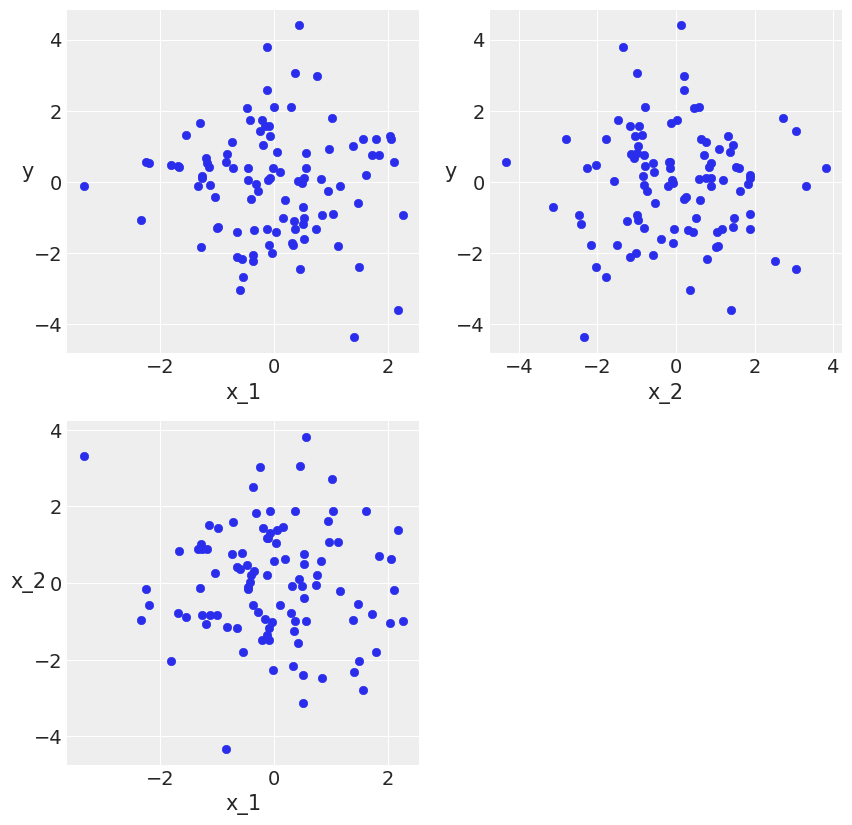

In [83]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)
plt.savefig('B11197_03_20.png', dpi=300)

The variable beta is a Gaussian with shape=2, one slope per each independent variable
We define the variable using the dot product function pm. math. dot()

In [78]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X_centered, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α_tmp]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:10<00:00, 486.03draws/s]


### 完全标准化以后的数据 y_centered  x_centered 

In [152]:
with pm.Model() as model_mlr1:
    α = pm.Normal('α', mu=y.mean(), sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X_centered, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_centered)

    trace_mlr1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:10<00:00, 473.54draws/s]


In [79]:
varnames = ['α', 'β', 'ϵ']
#az.plot_trace(trace_mlr, var_names=varnames);

In [145]:
az.summary(trace_mlr)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α_tmp,14.597,0.049,14.508,14.691,0.001,0.000,4809.0,4809.0,4826.0,3090.0,1.0
β[0],0.968,0.045,0.888,1.058,0.001,0.000,4606.0,4606.0,4606.0,3319.0,1.0
β[1],1.469,0.032,1.407,1.529,0.000,0.000,5348.0,5348.0,5338.0,3046.0,1.0
ϵ,0.474,0.035,0.410,0.537,0.001,0.000,4056.0,3889.0,4318.0,3208.0,1.0
α[0],1.864,0.467,1.012,2.813,0.007,0.005,4474.0,4275.0,4488.0,2808.0,1.0


![title](3_6.png)

### $y-\vec{y}=\alpha-\alpha^{'}+\beta x-\beta^{'}\vec{x}$ 
### $y=\alpha-\alpha^{'}+\beta x-\beta^{'}\vec{x}+\vec{y}$ 
### $y=(\alpha-\alpha^{'}+\vec{y}-\beta^{'}\vec{x})+\beta x$ 
### $\alpha=\vec{y}-\alpha^{'}-\beta^{'}\vec{x}  $  
 $if \alpha^{'}=0  $  and  $ \beta^{'}=\beta$ 
### 推到结果$\alpha=\vec{y}-\beta\vec{x}  $  书上有问题，参考下方的结果

In [155]:
y.mean()-np.dot([0.970,1.470],X_mean.T)

array([1.83866724])

In [153]:
az.summary(trace_mlr1, var_names=varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.000,0.047,-0.087,0.087,0.001,0.001,5960.0,1758.0,5960.0,3278.0,1.0
β[0],0.969,0.044,0.884,1.051,0.001,0.000,4085.0,4085.0,4095.0,2905.0,1.0
β[1],1.470,0.033,1.406,1.531,0.001,0.000,4080.0,4080.0,4087.0,3001.0,1.0
ϵ,0.474,0.034,0.412,0.539,0.000,0.000,4696.0,4625.0,4756.0,3122.0,1.0


在以下各节中，我们将重点介绍在分析多元回归模型的结果（尤其是斜率的解释）时应采取的一些预防措施。 可以理解的一个重要信息是，在多元线性回归中，每个参数仅在其他参数的上下文中才有意义。

## Confounding variables and redundant variables 混杂变量和冗余变量

想象以下情况。 我们有一个变量z与预测变量x相关，同时又与预测变量y相关。 假设变量z是引起x和y的变量。 例如，z可能是工业革命（一个非常复杂的变量！），x是海盗数量，y是CO 2浓度。 Pastafarian读者应该非常熟悉这个示例。 如果我们从分析中省略z，则最终可能会在x和y之间形成良好的线性关系，甚至可以从x预测y。 但是，如果我们的兴趣在于低估全球变暖，那么我们完全可能会错过与这些变量相关的实际机制的真实情况。

我们已经讨论了相关性并不意味着因果关系。不一定是正确的原因之一是我们可能从分析中忽略了变量。发生这种情况时，被称为混杂变量或混杂因素。在许多实际情况下，很容易错过。也许我们没有测量它，或者它在发送给我们的数据集中不存在，或者我们甚至认为它可能与我们的问题无关。在分析中不考虑混杂变量可能导致我们建立虚假相关。当我们尝试解释某事时，这始终是一个问题，而当我们尝试预测某事而又不关心理解其基本机制时，这也可能是有问题的。了解机制有助于我们将学到的知识转化为新的情况。盲目预测并不总是具有良好的可传递性。例如，一个国家生产的运动鞋数量可以用作衡量其经济实力的容易衡量的指标，但是对于其他具有不同生产矩阵或文化背景的国家来说，这可能是一个可怕的预测指标。

我们将使用综合数据来探讨混杂变量的概念。 以下代码将混杂变量模拟为x1。 注意此变量如何影响x2和y：

In [81]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

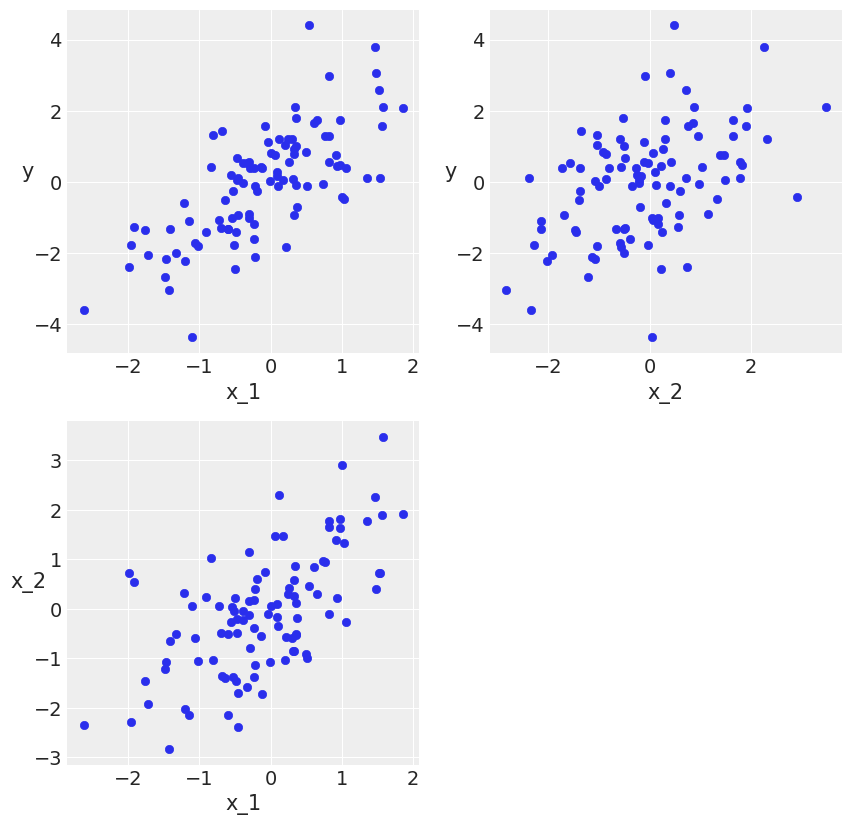

In [84]:
scatter_plot(X, y)
plt.savefig('B11197_03_21.png', dpi=300)

In [85]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:10<00:00, 499.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β1, α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:09<00:00, 537.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 5000/5000 [00:09<00:00, 510.99draws/s]


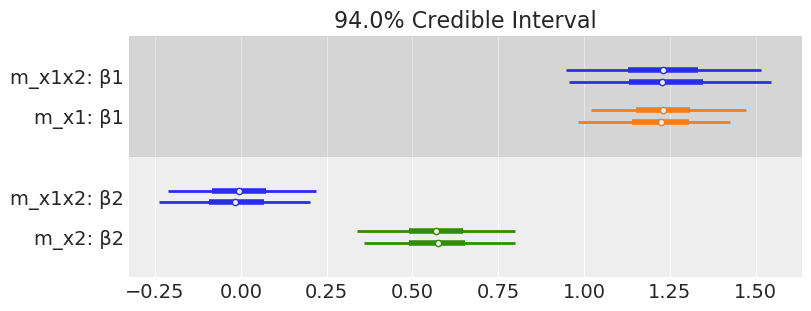

In [86]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=False, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_22.png', dpi=300)

As we can see, for model m_x1x2 is around zero, indicating an almost null
contribution of the variable to explain . This is interesting because we
already know (check the synthetic data) that the really important variable is
. Also notice—and this is really important—that for model m_x2 is
around 0.55. This is larger than for model m_x1x2 . The power of to predict
is reduced when we take into account ; the information in is redundant
given .

## Multicollinearity or when the correlation is too high 多重共线性或相关性太高

In [87]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

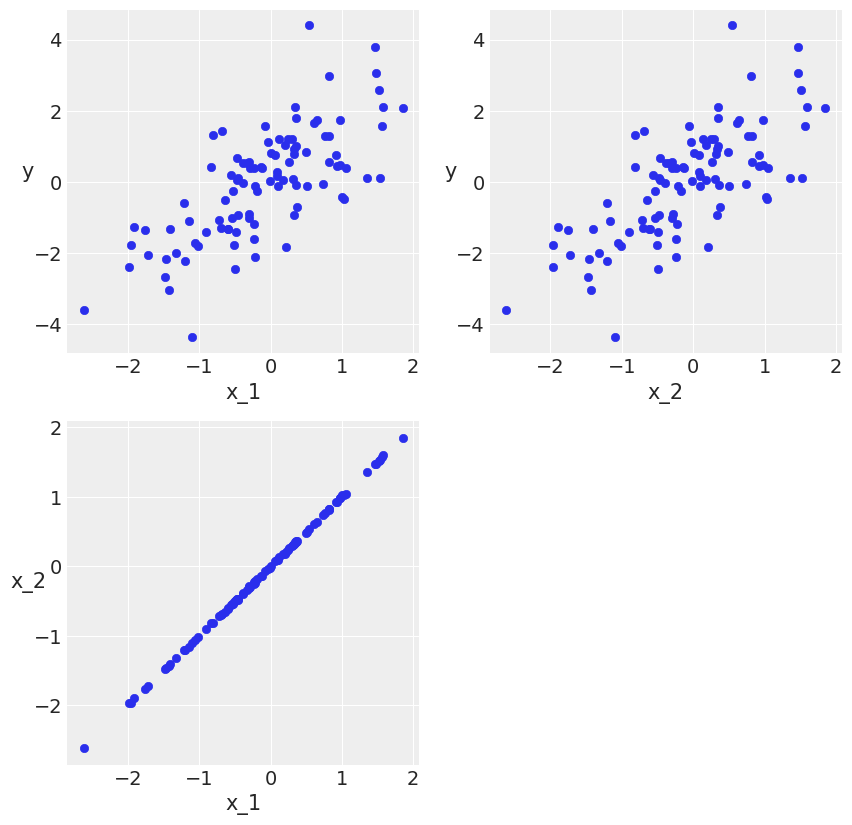

In [88]:
scatter_plot(X, y)
plt.savefig('B11197_03_23.png', dpi=300)

在前面的示例中，我们看到了多元线性回归模型对冗余变量的反应，并看到了考虑可能混杂变量的重要性。 现在，我们将前面的示例进行到极致，看看当两个变量高度相关时会发生什么。 为了研究此问题及其推论的后果，我们将使用与以前相同的综合数据和模型，但是现在，我们将通过减少添加到x1以获得x2的高斯噪声量来提高x1和x2之间的相关度：

数据生成代码中的这种更改实际上等效于将零与x1相加，因此，对于所有实际目的，这两个变量都是相等的。 然后，您可以尝试更改比例尺的值并使用较少的极值，但是现在我们要使事情变得清晰。 生成新数据后，检查散点图是什么样的：

In [89]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_red = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 5000/5000 [01:17<00:00, 64.70draws/s]


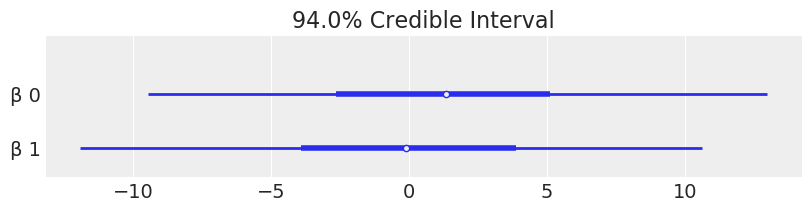

In [90]:
az.plot_forest(trace_red, var_names=['β'], combined=True, figsize=(8, 2))
plt.savefig('B11197_03_24.png', dpi=300)

系数的HPD可疑地宽。 通过系数散点图，我们可以了解发生了什么：

哇！ $ \ beta $的边缘后验是一个非常狭窄的对角线。 当一个系数上升时，另一个系数必须下降。 两者是有效相关的。 这只是模型和数据的结果。 根据我们的模型，平均$ \ mu $为：

事实证明，影响$ \ mu $的是$ \ beta1 $和$ \ beta2 $的总和，而不是它们的分隔值。 只要得到$ \ beta2 $，我们就可以使$ \ beta1 $越来越小。 我们实际上没有两个x变量，因此实际上我们没有两个$ \ beta $参数。 我们说模型是不确定的（或者等效地，数据无法限制模型中的参数）。 在我们的示例中，有两个原因导致无法在正负无穷间隔内自由移动。
首先，两个变量几乎相同，但是它们并不完全相等，其次，也是最重要的一点是，我们事先限制了$ \ beta $可以取的合理值。

此示例有两点需要注意。 首先，后验只是我们的数据和模型的逻辑结果，因此对于$ \ beta $获得如此宽的分布没有错。 这就是生活。 其次，我们可以依靠此模型进行预测。 例如，尝试进行后验预测检查； 模型预测的值与数据一致； 该模型很好地捕获了数据。 第三，这可能不是理解我们问题的很好模型。 仅从模型中删除变量之一可能更聪明。 我们最终将获得一个模型，该模型可以像以前一样预测数据，但是具有更简单（更简单）的解释。

在任何真实的数据集中，相关性都会在某种程度上存在。两个或多个变量之间的相关性应该有多强才能成为问题？好吧0.9845不只是在开玩笑。不幸的是，统计是一门很少有魔术数字的学科。在运行任何贝叶斯模型之前，总是有可能做一个相关矩阵，并检查具有高相关性（例如，高于0.9左右）的变量。然而，这种方法的问题在于，真正重要的不是我们可以在相关矩阵中观察到的成对相关，而是模型内部变量的相关性，并且正如我们已经看到的，变量在孤立状态下的行为与放在模型中当在多元回归模型中将其他变量放在上下文中时，两个或多个变量可以增加或减少它们的相关性。与往常一样，强烈建议对后部进行仔细检查，并采用迭代关键方法进行模型构建，这可以帮助我们发现问题并理解数据和模型。

就像快速指南一样，如果我们找到高度相关的变量，该怎么办？

如果相关性确实很高，则可以从分析中消除变量之一； 鉴于两个变量都具有相似的信息，因此我们通常忽略不了的信息。 我们可以基于纯粹的方便性消除变量，例如删除我们学科中鲜为人知的变量或难以解释或衡量的变量。

另一种可能性是创建一个平均冗余变量的新变量。 更复杂的版本是使用变量减少算法，例如主成分分析（PCA）。 PCA的问题在于，结果变量是原始变量的线性组合，通常会混淆结果的可解释性。

另一个解决方案是放宽优先级，以限制系数可以采用的合理值。 在第6章“模型比较”中，我们简要讨论了此类先验的一些选择，称为正则化先验。 

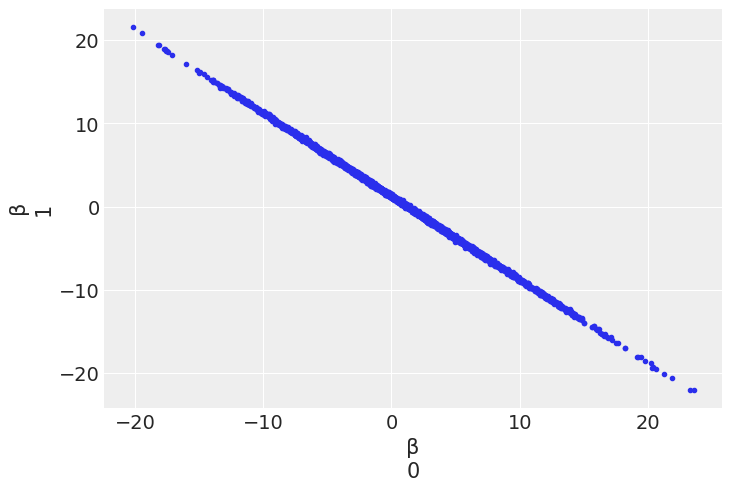

In [91]:
az.plot_pair(trace_red, var_names=['β'])
plt.savefig('B11197_03_25.png', dpi=300)

## Masking effect variables  掩蔽效果变量

变量如何影响结果的一个棘手的例子是掩盖效果变量。 让我们创建一个玩具数据集来说明这种现象。 基本上，我们正在创建两个自变量（x1和x2）。 它们彼此正相关，并且与y相关，但方向相反; x1正相关，x2负相关：

In [92]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

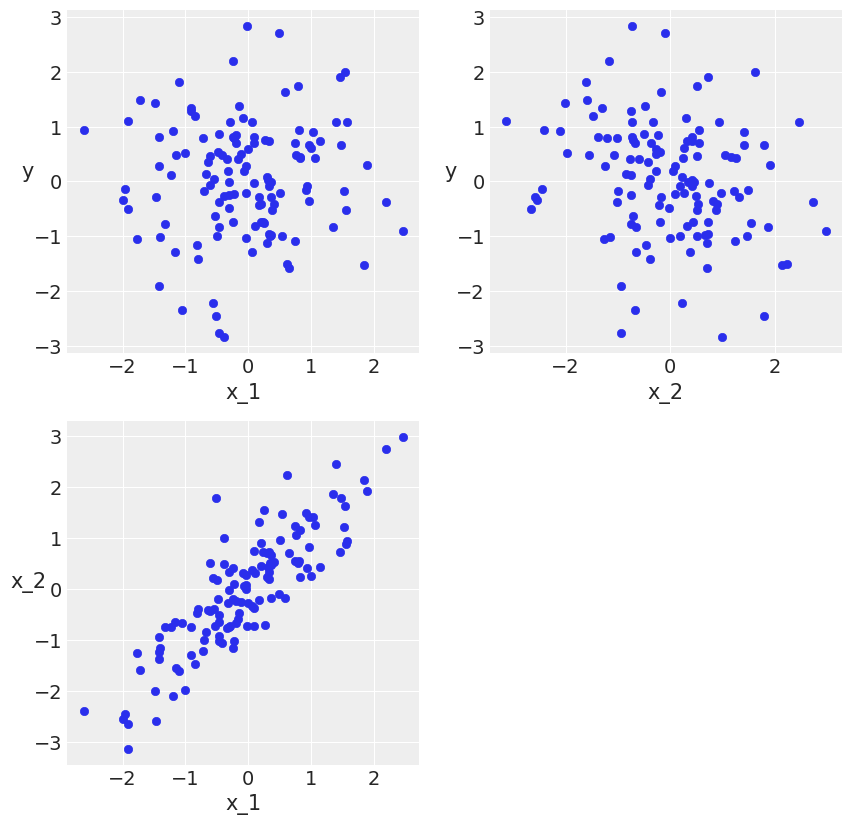

In [93]:
scatter_plot(X, y)
plt.savefig('B11197_03_26.png', dpi=300, figsize=(5.5, 5.5))

In [94]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(1000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(1000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, β1, α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 3000/3000 [00:09<00:00, 306.13draws/s]
The acceptance probability does not match the target. It is 0.8801545096578106, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β1, α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 3000/3000 [00:08<00:00, 352.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β2, α]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 3000/3000 [00:07<00:00, 387.58draws/s]


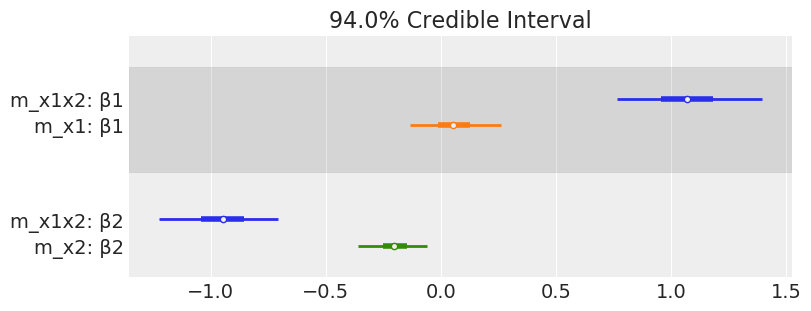

In [95]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_27.png', dpi=300, bbox_inches='tight')

根据后验，m_x1x2的$ \ beta $的值接近1和-1（根据我们生成数据的方式，这是预期的）。 对于简单的线性回归模型，即当我们单独研究每个变量时，我们可以看到$ \ beta $的值更接近于零，表明效果较弱。

注意，x1与x2相关。 实际上，当x1增加时，x2也增加。 还要注意，当y增加时，x1也增加，但是x2减少。 由于这种特殊的安排，除非将两个变量都包含在同一线性回归中，否则我们会部分抵消效果。 线性回归模型能够消除这些影响，因为该模型正在为每个数据点学习x1对y的贡献是x2的值，而x2则相反。

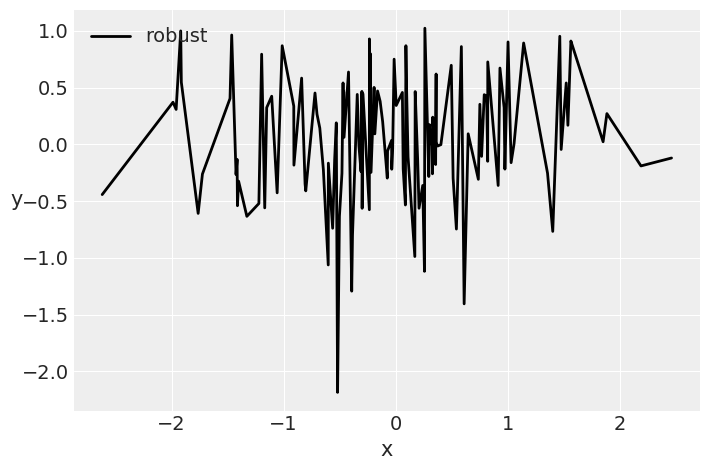

In [157]:
alpha_m = trace_x1x2['α'].mean()
beta_m1 = trace_x1x2['β1'].mean()
beta_m2 = trace_x1x2['β2'].mean()
order = np.argsort(x_1)
y=alpha_m + beta_m1 * x_1+beta_m2 * x_2
plt.plot(x_1[order],y[order] , c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

In [99]:
beta_m2

-0.9507223761021039

## Adding interactions 增加交叉项

到目前为止，在多元回归模型的定义中，（隐式地）宣布xi的变化会导致y的恒定变化，同时保持其余预测变量的值固定。 但是，当然，这不一定是正确的。 xi的变化可能会影响y，而y会受到xj的变化调制。 这种行为的一个典型例子是药物之间的相互作用。 例如，增加药物A的剂量会对患者产生积极影响。 在不存在药物B的情况下（或对于低剂量的B而言），这是正确的，而对于增加B的剂量，A的作用为阴性（甚至致命）。

这个非加性术语是统计学中称为交互作用的示例。 还有其他介绍交互的方法，但是我们将讨论限于乘数案例，因为它是交互的最常见表达。

![title](3_5.png)

相互作用项可以理解为线性模型。 因此，均值的表达式是一个线性模型，其中包含线性模型！

相互作用是对称的。 我们可以将其视为x1的斜率作为x2的函数，同时将x2的斜率作为x1的函数。

在没有交互作用的多元回归模型中，我们得到一个超平面，即平坦的超曲面。 相互作用项在这种超曲面中引入了曲率。 这是因为斜率不再是恒定的，而是另一个变量的函数。

系数$ \ beta1 $仅在x2 = 0时描述了预测变量x1的影响。 这是正确的，因为对于该值$ \ beta x2 = 0 $，然后x1的斜率减小为$ \ beta x1 $。 通过对称性，可以将相同的推理应用于$ \ beta2 $。

## Variable variance  可变方差

我们一直在使用线性基序对分布的均值进行建模，并且在上一节中，我们已将其用于对相互作用进行建模。 当恒定方差的假设没有意义时，我们还可以使用它来建模方差（或标准差）。 对于这些情况，我们可能希望将方差视为因变量的（线性）函数。

世界卫生组织（WHO）和世界各地的其他卫生机构收集新生儿和幼儿的数据，并设计生长图表标准。 这些图表是儿科工具包的重要组成部分，也是衡量人群总体福祉的指标，以便制定与健康相关的政策，计划干预措施并监测其效果http: //www. who. int/childgrowth/en/

这种数据的一个例子是新生/幼儿女孩的身高（身高）与年龄（月）的关系：

,Month,Lenght
0,0,48.5
1,0,50.5
2,0,50.5
3,0,52.0
4,0,47.5
...,...,...
795,24,87.5
796,24,82.5
797,24,88.5
798,24,89.0


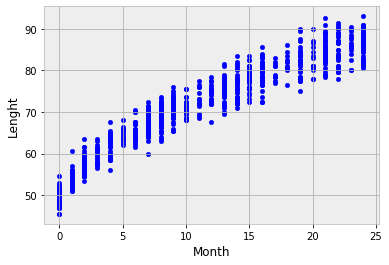

In [87]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')
plt.savefig('B11197_03_28.png', dpi=300)
data

为了对这些数据进行建模，与以前的模型相比，我们将引入三个新元素：

ϵ现在是x的线性函数。 为此，我们添加了两个新参数γ和δ。 它们是α和β的直接类似物。

均值的线性模型是 $\sqrt x$ 的函数。 这只是将线性模型拟合到曲线的简单技巧。

我们定义一个共享变量x_shared。 在模型拟合之后，我们将使用它来更改x变量的值（在本示例中为Month），而无需重新拟合模型。 我们为什么要这样做很快将变得清楚：

In [90]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    x_shared = shared(data.Month.values * 1.)

    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)
    #mu = α + β * x_shared**0.5
    #sd = γ + δ * x_shared
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=data.Lenght)

    trace_vv = pm.sample(1000, tune=1000,cores=1)
    
    posterior_predictive = pm.sample_posterior_predictive(trace_vv)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [δ, γ, β, α]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 500.13it/s]


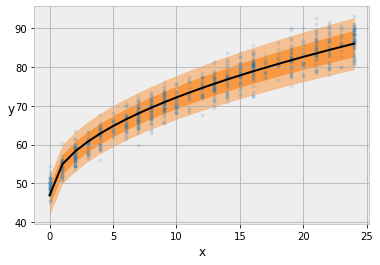

In [91]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

μ_m = trace_vv['μ'].mean(0)
ϵ_m = trace_vv['ϵ'].mean(0)

plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month, μ_m + 1 * ϵ_m, μ_m -
                 1 * ϵ_m, alpha=0.6, color='C1')
plt.fill_between(data.Month, μ_m + 2 * ϵ_m, μ_m -
                 2 * ϵ_m, alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_29.png', dpi=300)

图3.29显示了我们模型的结果。 μ的平均值用黑色曲线表示，两个半透明的橙色带分别表示1和2个标准偏差：

在撰写本书时，我的女儿已经两周大（0.5个月），因此我想知道她的身高与我们刚刚创建的增长图相比如何。 回答此问题的一种方法是询问模型中0.5个月婴儿的可变长度分布。 使用PyMC3，我们可以通过sample_posterior_predictive函数来问这个问题。

此函数的输出将是y的样本，该样本基于观察到的数据和估计的参数分布（包括不确定性）。 唯一的问题是，根据定义，此函数将针对x的观测值返回y的预测，而未观测到0.5个月（我关心的值）； 所有度量均报告为整数月。 获得x的未观察值的预测的更简单方法是*定义一个共享变量（作为模型的一部分）*，然后在从后验预测分布采样之前立即更新该共享变量的值：

现在，我们可以绘制两个星期大的婴儿的预期身长分布，并计算其他数量，例如，给定婴儿的身长，一个孩子的百分位数。 请检查以下代码块，并参见图3.30的示例：

In [111]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 585.50it/s]


In [112]:
y_ppc

array([52.83114762, 50.50039695, 51.01327201, ..., 50.17020377,
       53.00201322, 52.48242354])

In [120]:
data_ppc1 = az.from_pymc3(trace=trace_vv, posterior_predictive=posterior_predictive)
data_ppc1

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> observed_data

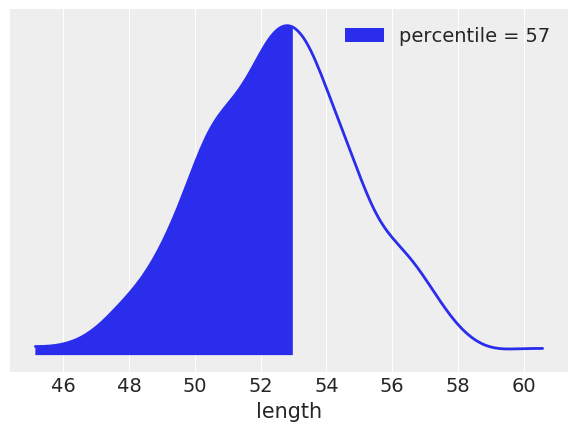

In [105]:
ref = 53
density, l, u = az._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
                 label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()
plt.savefig('B11197_03_30.png', dpi=300)

## 总结

简单的线性回归是一种可用于预测和/或解释另一个变量的模型。 使用机器学习语言，这是监督学习的一种情况。 从概率的角度来看，线性回归模型是高斯模型的扩展，在该模型中，均值不是直接估算的，而是作为预测变量和一些其他参数的线性函数计算的。 尽管高斯分布是因变量的最常见选择，但我们可以自由选择其他分布。 学生的t分布是一种替代方法，它在处理潜在异常值时特别有用。 在下一章中，我们将探讨其他替代方法。

在本章中，我们还讨论了Pearson相关系数，这是两个变量之间线性相关的最常用度量，并且我们学会了使用多元高斯分布从数据和后验预测样本中计算贝叶斯版本。扩展线性回归模型的一种有用方法是对其进行分层处理，这提供了收缩的好处。使用PyMC3非常简单。我们还简要讨论了至少在没有机械模型的情况下，不要将相关性解释为因果关系的重要性。听起来令人惊讶，我们可以使用线性模型拟合曲线。我们用两个例子展示了这一点。多项式回归，并取自变量的平方根。简单线性回归的另一扩展是使用通常称为多重线性回归的方法处理多个独立变量。为了避免在解释这些类型的模型时出现错误和问题，需要采取一些预防措施，我们使用了一些示例来说明这一点。使用线性模体的其他方法是对交互进行建模，而另一种方法是处理因变量的非恒定方差。

In [ ]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sd=ϵ, nu=ν, observed=y_4)
    trace_t2 = pm.sample(2000)